In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set()
sns.set_context('poster'); plt.style.use('fivethirtyeight')

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

from IPython.display import HTML

In [2]:
def percentify_y():
    plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    
def percentify_x():
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    
def output_figure(filename):
    """
    Save the most recently generated chart as a png with the filename passed as an argument
    """
    plt.tight_layout()
    plt.savefig('./charts/coding/' + filename + '.png', dpi=200)

In [3]:
# Downloaded CSV for all complaints with a narrative (i.e., text explanation) from 
# http://www.consumerfinance.gov/complaintdatabase/

df = pd.read_csv('raw/Consumer_Complaints_with_Consumer_Complaint_Narratives.csv', index_col='Complaint ID')
df = df[df['Product'] == 'Credit card'].copy()

In [4]:
df['Relief Indicator'] = [x in {'Closed with non-monetary relief', 'Closed with monetary relief'} for x in df['Company response to consumer']]

df = df.reset_index()[['Relief Indicator', 'Consumer complaint narrative']].copy()
df.columns = ['Relief','Complaint']

In [5]:
#HTML for pasting DF into WordPress

df.head(5).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Relief</th>\n      <th>Complaint</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>True</td>\n      <td>Home Depot habitually credits my account a wee...</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>False</td>\n      <td>Dear representatives of The Consumer Financial...</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>False</td>\n      <td>I applied for a credit card with USAA and I wa...</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>False</td>\n      <td>I believe what happened was a system error. I ...</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>True</td>\n      <td>I filed a Ch. XXXX Bankruptcy in the XXXX XXXX...</td>\n    </tr>\n  </tbody>\n</table>'

In [6]:
complaints = df['Complaint'].values

vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB()
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10 = pd.concat([top_10,bottom_10])

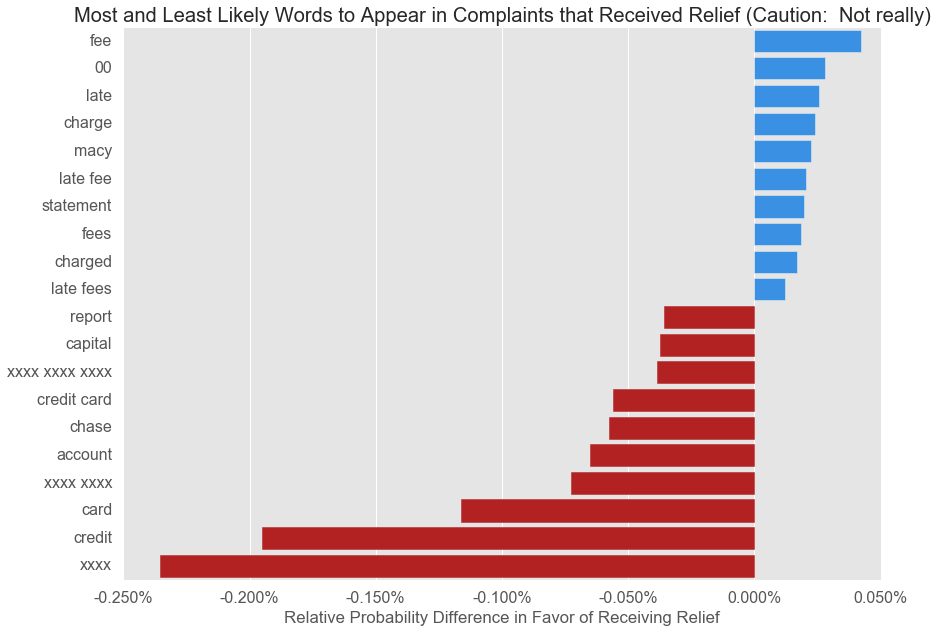

In [7]:
with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10.index, x=top_and_bottom_10, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Receiving Relief')
    plt.title('Most and Least Likely Words to Appear in Complaints that Received Relief (Caution:  Not really)')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')
    output_figure('first_shot_top_bottom_ten')

In [88]:
# Word counts by class

relief_complaints = df.loc[df['Relief']==True,'Complaint'].values
vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
X = vect.fit_transform(relief_complaints)
# Class word count, total count of xxxx
(X.sum(axis=1).sum(),X[:,vect.get_feature_names().index('xxxx')].sum())

(598600, 18374)

In [89]:
relief_complaints = df.loc[df['Relief']==False,'Complaint'].values
vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
X = vect.fit_transform(relief_complaints)
# Class word count, total count of xxxx
(X.sum(axis=1).sum(),X[:,vect.get_feature_names().index('xxxx')].sum())

(994324, 27998)

In [90]:
relief_complaints = df.loc[df['Relief']==True,'Complaint'].values
vect = CountVectorizer(ngram_range=(1,1), stop_words='english')
X = vect.fit_transform(relief_complaints)
# Class word count, total count of xxxx
(X.sum(axis=1).sum(),X[:,vect.get_feature_names().index('xxxx')].sum())

(201584, 18374)

In [91]:
relief_complaints = df.loc[df['Relief']==False,'Complaint'].values
vect = CountVectorizer(ngram_range=(1,1), stop_words='english')
X = vect.fit_transform(relief_complaints)
# Class word count, total count of xxxx
(X.sum(axis=1).sum(),X[:,vect.get_feature_names().index('xxxx')].sum())

(335216, 27998)

In [95]:
# Words only vocab count
vect = CountVectorizer(ngram_range=(1,1), stop_words='english')
X = vect.fit_transform(complaints)
X.shape[1]

15569

In [96]:
# 1-3-grams vocab count
# Words only vocab count
vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
X = vect.fit_transform(complaints)
X.shape[1]

682446

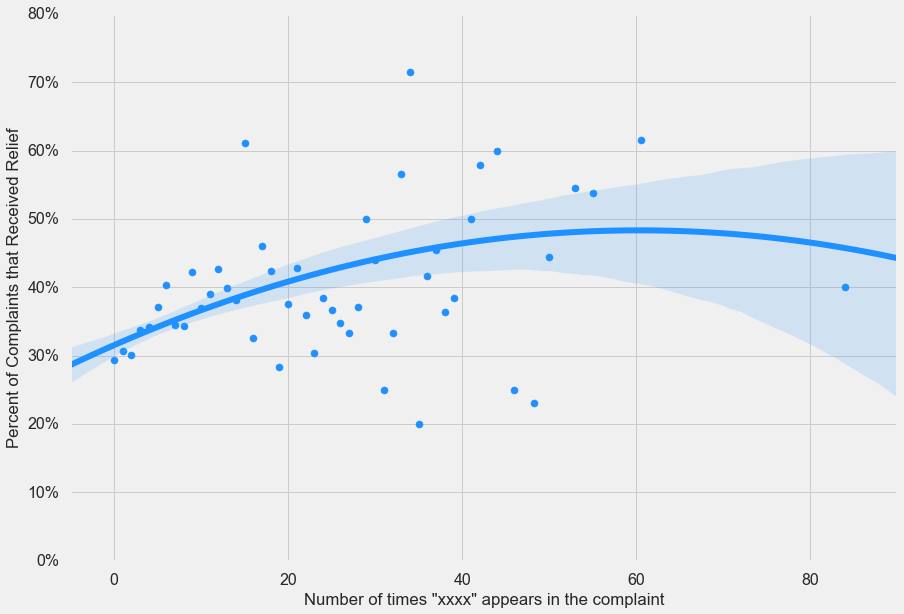

In [8]:
df['XXXX Count'] = [x.lower().count('xxxx') for x in complaints]

sns.regplot(x=df['XXXX Count'], y=100*df['Relief'], x_bins=500, x_ci=None, order=2, color='DodgerBlue')
plt.xlim((-5,90))
percentify_y()
plt.ylabel('Percent of Complaints that Received Relief')
plt.xlabel('Number of times "xxxx" appears in the complaint')
output_figure('xxxx_versus_perc_relief')

In [31]:
word_count = pd.DataFrame(X.sum(axis=0).transpose(), index=words, columns=['WordCount'])

In [34]:
word_count = word_count.query('WordCount==1')

In [38]:
df['Relief'].values

array([ True, False, False, ..., False, False,  True], dtype=bool)

In [39]:
from scipy.sparse import hstack


<5826x682446 sparse matrix of type '<class 'numpy.int64'>'
	with 1315368 stored elements in Compressed Sparse Row format>

In [48]:
boolz = [int(x) for x in df['Relief'].values]

In [41]:
X.shape

(5826, 682446)

In [45]:
df['Relief'].values

array([ True, False, False, ..., False, False,  True], dtype=bool)

In [9]:
likelihood_xxxx_df = likelihood_df.loc[['xxxx' in x for x in likelihood_df.index],:].copy()

likelihood_xxxx_df['Percent More Likely to Get Relief'] = likelihood_xxxx_df.eval('100 * (exp(Relief) - exp(NoRelief))')

top_10 = likelihood_xxxx_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_xxxx_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10 = pd.concat([top_10,bottom_10])

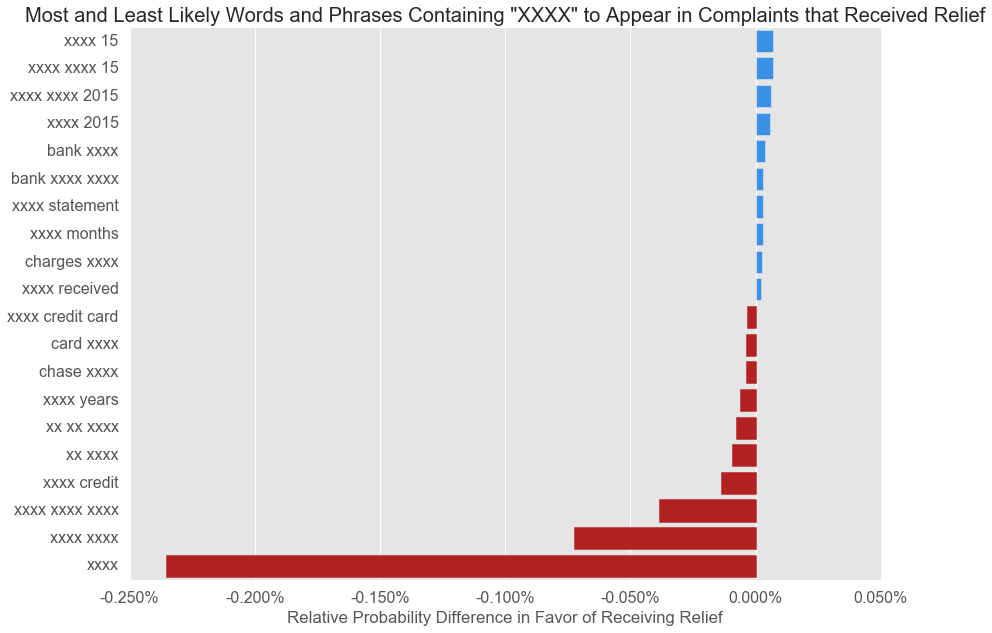

In [10]:
with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10.index, x=top_and_bottom_10, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Receiving Relief')
    plt.title('Most and Least Likely Words and Phrases Containing "XXXX" to Appear in Complaints that Received Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')
    output_figure('second_shot_top_bottom_ten')

In [11]:
# Are there enough of those positive bars--and do they have high enough of a value--for them to reasonably be able
# to fit the positive trend?

likelihood_xxxx_df['Positive Indicator'] = (likelihood_xxxx_df['Percent More Likely to Get Relief'] >=0)

likelihood_xxxx_df.groupby('Positive Indicator')['Percent More Likely to Get Relief'].sum()

Positive Indicator
False   -2.841839
True     2.905780
Name: Percent More Likely to Get Relief, dtype: float64

In [12]:
likelihood_xxxx_df.groupby('Positive Indicator')['Percent More Likely to Get Relief'].count()

Positive Indicator
False    40384
True     27082
Name: Percent More Likely to Get Relief, dtype: int64

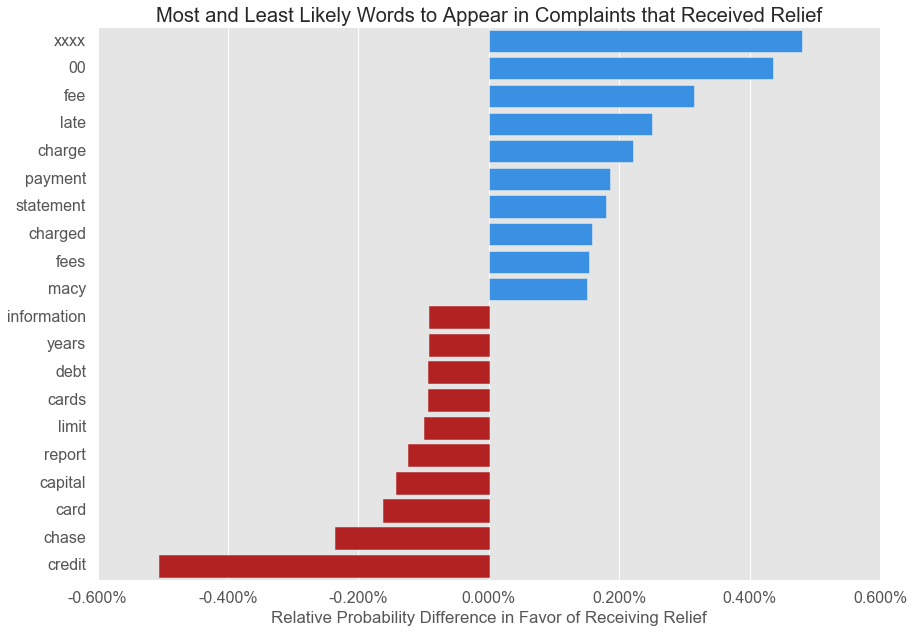

In [13]:
# Redoing analysis without bi- and tri-grams

vect = CountVectorizer(ngram_range=(1,1), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB()
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10 = pd.concat([top_10,bottom_10])

with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10.index, x=top_and_bottom_10, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Receiving Relief')
    plt.title('Most and Least Likely Words to Appear in Complaints that Received Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')
    output_figure('third_shot_top_bottom_ten_only_1_grams')

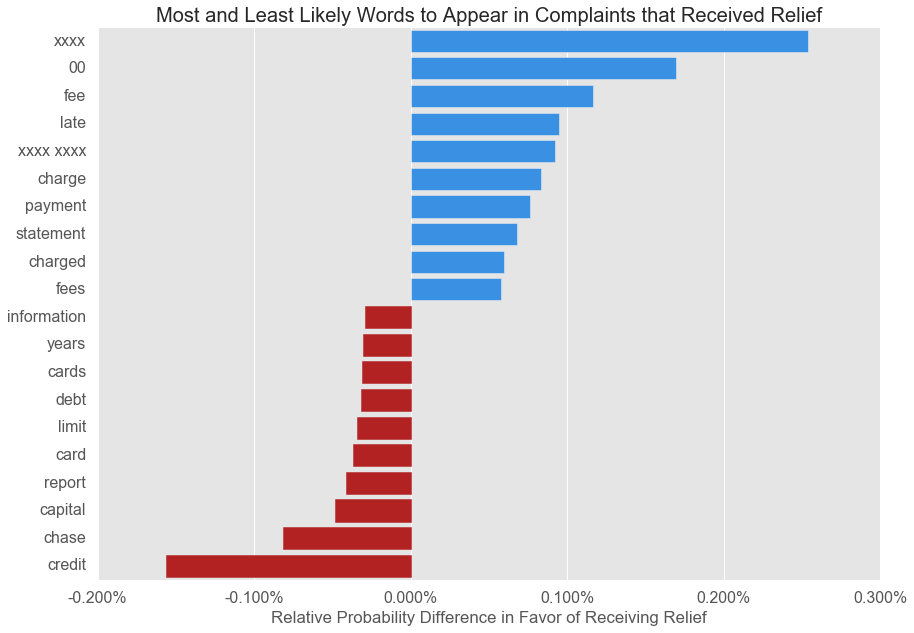

In [14]:
# Redoing analysis with bi- and tri-grams but without smoothing

vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB(alpha=0)
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10 = pd.concat([top_10,bottom_10])

with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10.index, x=top_and_bottom_10, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Receiving Relief')
    plt.title('Most and Least Likely Words and Phrases to Appear in Complaints that Received Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')
    output_figure('third_shot_top_bottom_ten_no_smoothing')

In [98]:
18374/201584

0.09114810699261847

In [100]:
27998/335216

0.08352226624027492

In [101]:
18375/(201584+15569)

0.08461775798630458

In [102]:
27998/(335216+15569)

0.07981527146257679

In [103]:
18374/598600

0.030694954894754427

In [104]:
27998/994324

0.028157823807933833

In [107]:
# Going to tri-grams increases WC relief by this percent:

100*((598600/201584)-1)

196.9481704897214

In [108]:
# Going to tri-grams increases WC non-relief by this percent:

100*((994324/335216)-1)

196.6218796238843

In [109]:
# So what happened here is...

"""
Since there's a lower word count in the relief class, adding the smoothing term to the denominator will decrease every single
one of the probabilities for P(word|relief) more than for P(word|no relief), shifting everything to more negative (see
side-by-side chart)

But, then why 'xxxx' in particular? Well, adding things to the denominator results in absolute decreases that are larger for values that are initially
higher (1/2+2) vs. (1/3+2) -> .5 goes down by .25 to .25; .3333 only goes down by .1333333 to .2.(. So since 'xxxx' has the highest term in
the data for P(word|relief), it decreases by the most

If look at side-by-side graph, why do some words like "Macy's" pop up relatively? Flip side of xxxx -- they're super rare, so lower
probabilities, so deflate less, so aren't as impacted in absolute relative difference
"""

'\nSince there\'s a lower word count in the relief class, adding the smoothing term to the denominator will decrease every single\none of the probabilities for P(word|relief) more than for P(word|no relief), shifting everything to more negative (see\nside-by-side chart)\n\nBut, then why \'xxxx\' in particular? Well, adding things to the denominator results in absolute decreases that are larger for values that are initially\nhigher (1/2+2) vs. (1/3+2) -> .5 goes down by .25 to .25; .3333 only goes down by .1333333 to .2.(. So since \'xxxx\' has the highest term in\nthe data for P(word|relief), it decreases by the most\n\nIf look at side-by-side graph, why do some words like "Macy\'s" pop up relatively? Flip side of xxxx -- they\'re super rare, so lower\nprobabilities, so deflate less, so aren\'t as impacted in absolute relative difference\n'

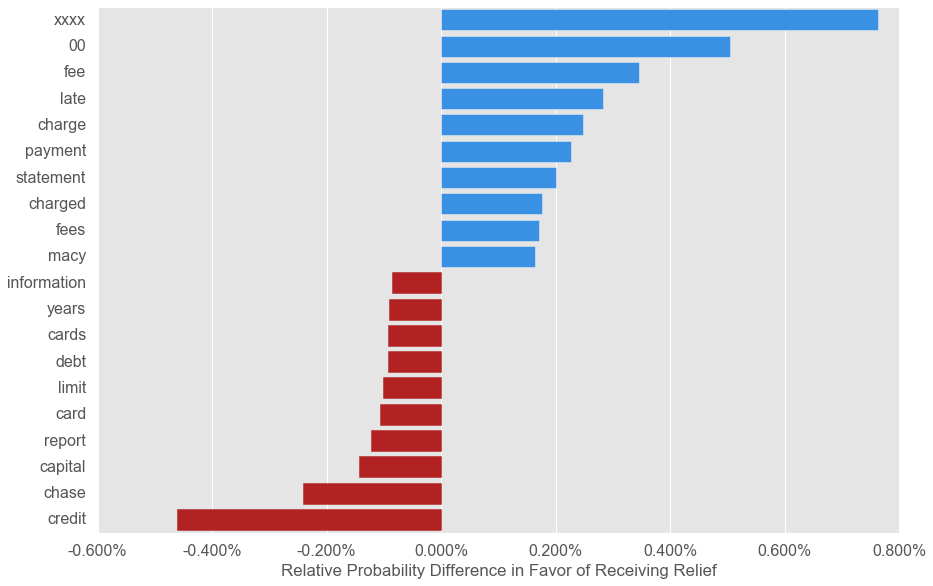

In [114]:
# Doing each n-gram separately and combining

complaints = df['Complaint'].values

vect = CountVectorizer(ngram_range=(1,1), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB(alpha=0)
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10_1_gram = pd.concat([top_10,bottom_10])

with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10_1_gram.index, x=top_and_bottom_10_1_gram, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Receiving Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')

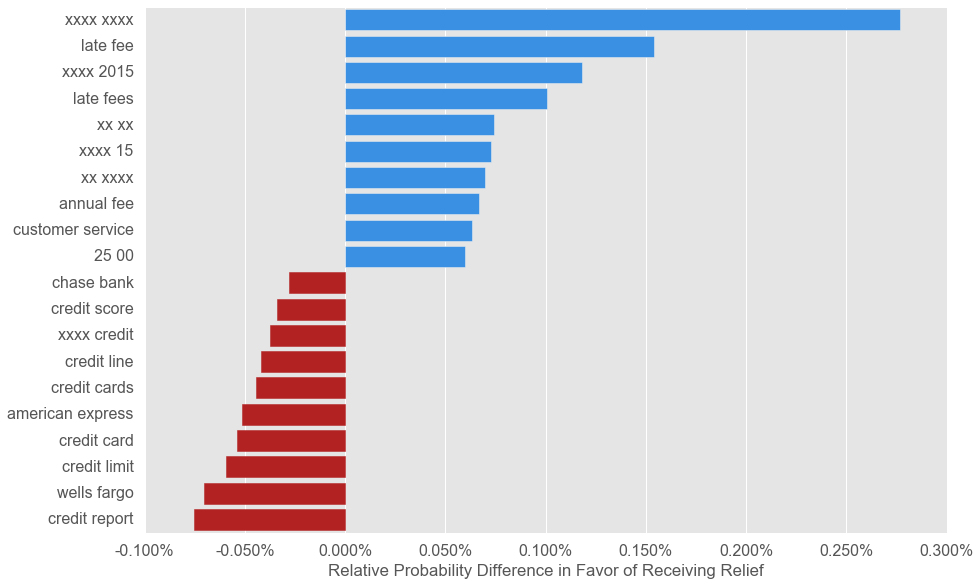

In [115]:
# Doing each n-gram separately and combining

complaints = df['Complaint'].values

vect = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB(alpha=0)
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10_2_gram = pd.concat([top_10,bottom_10])

with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10_2_gram.index, x=top_and_bottom_10_2_gram, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Receiving Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')

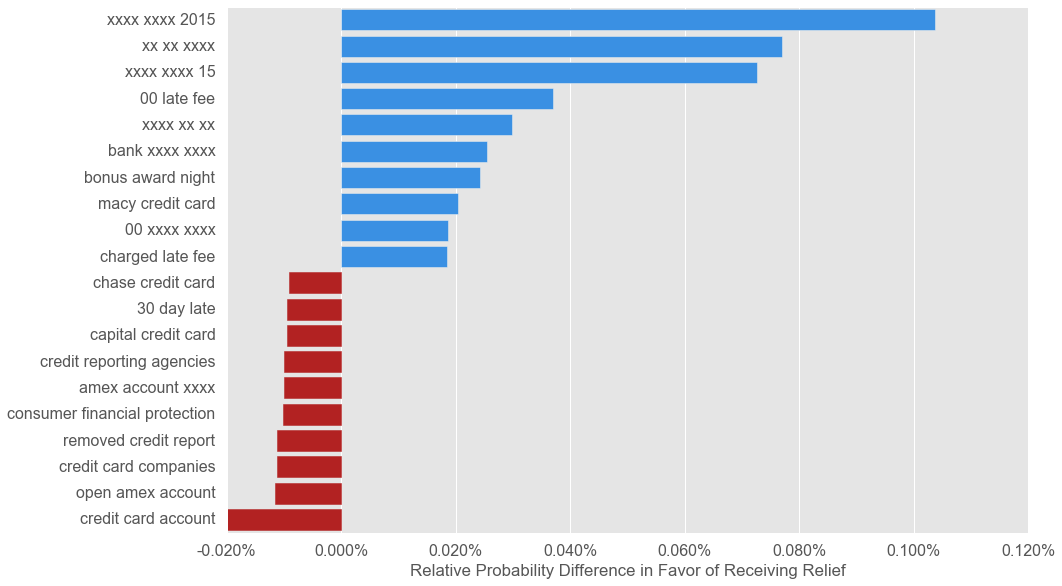

In [136]:
# Doing each n-gram separately and combining:  3-grams

complaints = df['Complaint'].values

vect = CountVectorizer(ngram_range=(3,3), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB(alpha=0)
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10_3_gram = pd.concat([top_10,bottom_10])

with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10_3_gram.index, x=top_and_bottom_10_3_gram, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Receiving Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')

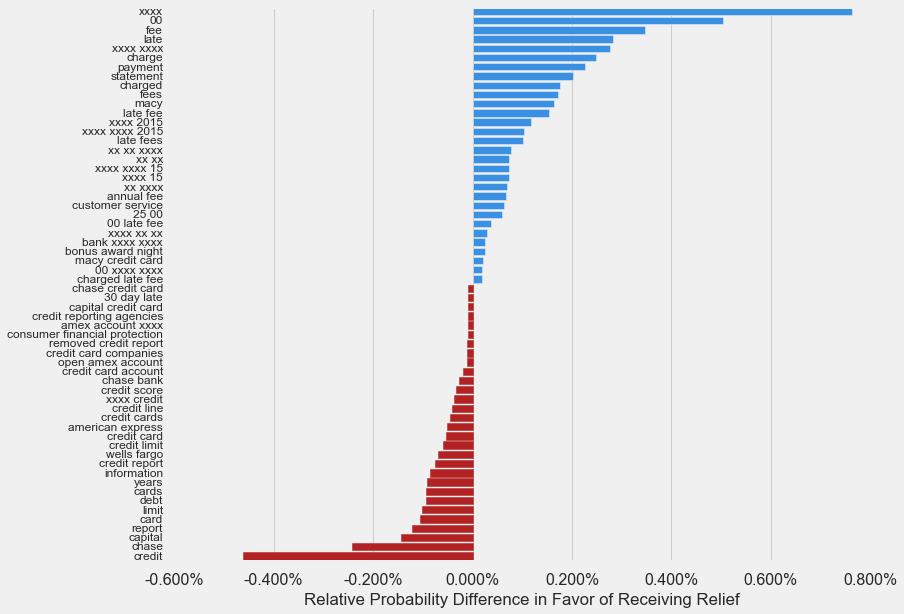

In [134]:
full_60 = pd.concat([top_and_bottom_10_1_gram,top_and_bottom_10_2_gram,top_and_bottom_10_3_gram]).sort_values(ascending=False)

with plt.style.context('fivethirtyeight'):
    sns.barplot(y=full_60.index, x=full_60, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Receiving Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[30:60]:
        bar.set_color('FireBrick')
    plt.yticks(fontsize=12)
    output_figure('full_60')
    
#Observation:  Larger N-grams have benefit of being more interpretable -- e.g., "amex account xxxx", "credit reporting agencies"